## Imports

In [2]:
from utils import dataset
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, DBSCAN
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline

# Load Dataset
Load the Million Song Dataset from 'YearPredictionsMSP.txt' (expected to be in the data folder)  
Dataset Source: https://archive.ics.uci.edu/ml/datasets/YearPredictionMSD  

The following information is from the UCI webpage for this dataset (linked above):

## Data Set Information:
You should respect the following train / test split:  
train: first 463,715 examples  
test: last 51,630 examples  
It avoids the 'producer effect' by making sure no song  
from a given artist ends up in both the train and test set.  

## Attribute Information:  
90 attributes, 12 = timbre average, 78 = timbre covariance  
The first value is the year (target), ranging from 1922 to 2011.  
Features extracted from the 'timbre' features from The Echo Nest API.  
We take the average and covariance over all 'segments', each segment  
being described by a 12-dimensional timbre vector.  

## Relevant Papers:
see the website: http://millionsongdataset.com/

In [3]:
# Load the year prediction dataset from data/YearPredictionMSD.txt
train, test = dataset.load_dataset("./data/YearPredictionMSD.txt", 463715)
print(f"Training set shape: {train.data.shape}")
print(f"Test set shape:     {test.data.shape}")

Training set shape: (463715, 90)
Test set shape:     (51630, 90)


## Normalization

In [4]:
# Normalize the training and test data
preprocessing.normalize(train.data, norm='l2', axis=1, copy=False)
preprocessing.normalize(test.data, norm='l2', axis=1, copy=False)

array([[ 0.01607807, -0.01087973,  0.01124632, ..., -0.00136662,
         0.01288736,  0.00253795],
       [ 0.03313346, -0.00181721,  0.02764532, ..., -0.00252199,
        -0.04337574, -0.00328028],
       [ 0.01554794,  0.00408662,  0.00374916, ..., -0.00371351,
         0.00909358, -0.00196716],
       ...,
       [ 0.00744298,  0.0020876 , -0.00638606, ..., -0.0010014 ,
         0.00890007, -0.00133487],
       [ 0.01035857,  0.00759515, -0.00078563, ...,  0.00476634,
         0.00347843,  0.00932261],
       [ 0.02740005,  0.03123568,  0.01394611, ..., -0.00291405,
         0.01709609,  0.00643218]])

## Dimensionality Reduction Using Truncated SVD

In [6]:
svd = TruncatedSVD(n_components=30, n_iter=7, random_state=42)
svd.fit(train.data)
train_data_svd = svd.transform(train.data)
test_data_svd = svd.transform(test.data)

# K-Means Clustering

In [7]:
kmeans = KMeans(n_clusters=12)
kmeans.fit(train_data_svd)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=12, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

### Visualize Truncated SVD Cluster

Text(0, 0.5, 'Truncated SVD Component 2')

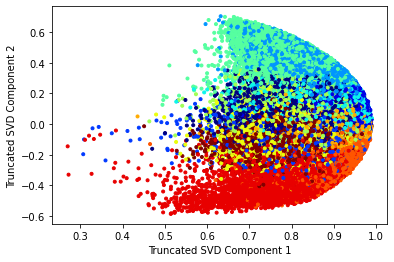

In [8]:
# Visualize clusters using first two components of TruncatedSVD
# dimensionality reduction
plt.figure()
plt.scatter(
    train_data_svd[:, 0], 
    train_data_svd[:, 1], 
    c=kmeans.labels_, 
    cmap="jet",
    marker='.'
)
plt.xlabel("Truncated SVD Component 1")
plt.ylabel("Truncated SVD Component 2")

### Create Elbow graph to see where optimal clustering is

In [9]:
# Run K-Means for various values of K
inertias = []
k_range = range(1, 15)
for k in k_range:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(train_data_svd)
    inertias.append(kmeans.inertia_)

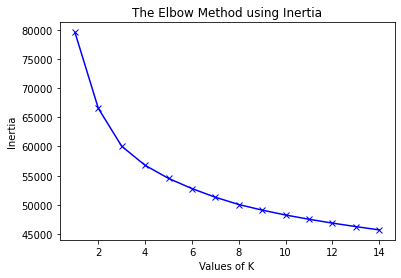

In [10]:
# Plot clustering inertia vs K
plt.plot(k_range, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

## DB Scan Example using TruncatedSVD

Text(0, 0.5, 'Truncated SVD Component 2')

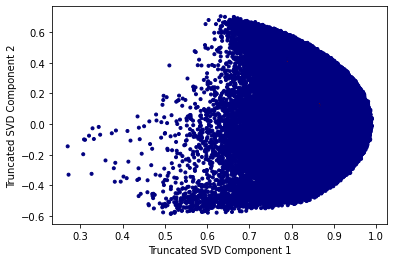

In [11]:
scaler = StandardScaler()
scaler.fit(train_data_svd)
train_data_scaled = scaler.transform(train_data_svd)
test_data_scaled = scaler.transform(test_data_svd)

# Cluster the data
dbscan = DBSCAN(eps=0.123, min_samples = 2)
dbscan.fit(train_data_scaled)

# Plot the cluster assignments
plt.scatter(
    train_data_svd[:, 0],
    train_data_svd[:, 1],
    c=dbscan.labels_,
    cmap="jet",
    marker='.'
)
plt.xlabel("Truncated SVD Component 1")
plt.ylabel("Truncated SVD Component 2")

## Attempt to predict which year a random song sample belongs to

In [12]:
def predict_year(kmeans, years, x):
    """Predict which year the samples belong to"""
    cluster_pred = kmeans.predict(x)
    years_pred = np.zeros(cluster_pred.shape, dtype=int)
    for label in set(cluster_pred):
        year = int(np.mean(years[label == kmeans.labels_]))
        years_pred[label == cluster_pred] = year
    return years_pred

years_pred = predict_year(kmeans, train.labels, test_data_svd)
years_act = test.labels
acc = np.mean(years_pred == years_act)
err = np.mean(np.abs(years_pred- years_act))
print(f"Year prediction accuracy for K-Means: {acc}")
print(f"Year prediction mean error for K-Means: {err} years")

Year prediction accuracy for K-Means: 0.03279101297695138
Year prediction mean error for K-Means: 8.132984698818516 years


### Predict year of a random test sample by comparing to closest K-Means centroid

In [13]:
# Choose a random sample from the test data
idx = np.random.choice(test_data_svd.shape[0], 1)
sample_data = test_data_svd[idx]

In [14]:
cluster_order = []
difference_matrix = []
SSE_diffs = []

for i in range(0, len(kmeans.cluster_centers_)):
    difference = kmeans.cluster_centers_[i] - sample_data
    difference_matrix.append(difference)

print(difference_matrix)

[array([[ 0.04941171, -0.6493647 , -0.1301745 , -0.12982492, -0.0879312 ,
        -0.03831522,  0.05506165, -0.0282447 ,  0.07555406,  0.03647321,
        -0.07703981, -0.00958972,  0.015344  ,  0.03451222, -0.00950315,
         0.06564928,  0.05046455,  0.00847778,  0.03786051, -0.02977027,
        -0.01721376, -0.00632735,  0.01484106, -0.00557226, -0.04953629,
        -0.0232242 ,  0.00329395, -0.01920797, -0.00331494,  0.00171954]]), array([[-0.02790274,  0.01786504, -0.23120905, -0.07808125,  0.00607076,
        -0.06070913,  0.0318627 , -0.01804084,  0.07343455,  0.06229212,
        -0.07654266, -0.00984645,  0.02700296,  0.03360926, -0.00332889,
         0.06391245,  0.03833717,  0.00269414,  0.03837603, -0.03427877,
        -0.02387838, -0.00094765,  0.01436906, -0.00397491, -0.04845657,
        -0.02405474,  0.00718427, -0.01505339, -0.00338995,  0.00144689]]), array([[ 1.89544931e-02, -1.09137936e-01, -2.45090638e-01,
        -2.75730721e-01, -1.20674552e-01, -8.23971201e-03,

In [15]:
order_matrix = []

for i in range(0, len(difference_matrix)):
    order = abs(np.mean(difference_matrix[i]))
    order_matrix.append(order)
    
print(order_matrix)

[0.02884971399137434, 0.00804126476278257, 0.01903031638918308, 0.020585894207559057, 0.026616887557274115, 0.02671854434681947, 0.016538619808187188, 0.00888723515488895, 9.584187566461984e-05, 0.019346977355142056, 0.016561038290348908, 0.017368200584274622, 0.03350645376239466, 0.028292397920491315]


### Random sample sill have the lowest min to the closest centroid

In [16]:
#smallest delta represents sample data closest to the centroid
index_min = np.argmin(order_matrix)
print("Closest centroid is index: ", index_min)

Closest centroid is index:  8


### Calculate year based on cluster index

In [17]:
print("possible year: ", train.labels[index_min])

possible year:  2001
